Running HMC with dual averaging and trajectory length 0.20...
0.25
0.125
find_reasonable_epsilon= 0.125
Done. Final epsilon = 0.300847.
(M+Madapt) / Functions called: 0.569866
Percentiles
[[-0.96223025 -1.92113153]
 [ 0.04036767  0.08803081]
 [ 1.00990273  2.01081402]]
Mean
[0.02628615 0.0528987 ]
Stddev
[1.01110121 2.01830967]


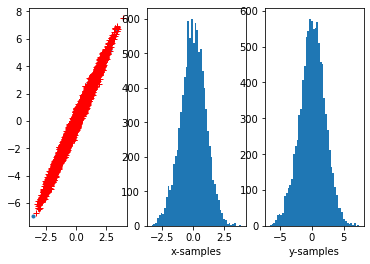

In [1]:
 
"""
This package implements the No-U-Turn Sampler (NUTS) algorithm 6 from the NUTS
paper (Hoffman & Gelman, 2011).
Content
-------
The package mainly contains:
  nuts6                     return samples using the NUTS
  test_nuts6                example usage of this package
and subroutines of nuts6:
  build_tree                the main recursion in NUTS
  find_reasonable_epsilon   Heuristic for choosing an initial value of epsilon
  leapfrog                  Perfom a leapfrog jump in the Hamiltonian space
  stop_criterion            Compute the stop condition in the main loop
A few words about NUTS
----------------------
Hamiltonian Monte Carlo or Hybrid Monte Carlo (HMC) is a Markov chain Monte
Carlo (MCMC) algorithm that avoids the random walk behavior and sensitivity to
correlated parameters, biggest weakness of many MCMC methods. Instead, it takes
a series of steps informed by first-order gradient information.
This feature allows it to converge much more quickly to high-dimensional target
distributions compared to simpler methods such as Metropolis, Gibbs sampling
(and derivatives).
However, HMC's performance is highly sensitive to two user-specified
parameters: a step size, and a desired number of steps.  In particular, if the
number of steps is too small then the algorithm will just exhibit random walk
behavior, whereas if it is too large it will waste computations.
Hoffman & Gelman introduced NUTS or the No-U-Turn Sampler, an extension to HMC
that eliminates the need to set a number of steps.  NUTS uses a recursive
algorithm to find likely candidate points that automatically stops when it
starts to double back and retrace its steps.  Empirically, NUTS perform at
least as effciently as and sometimes more effciently than a well tuned standard
HMC method, without requiring user intervention or costly tuning runs.
Moreover, Hoffman & Gelman derived a method for adapting the step size
parameter on the fly based on primal-dual averaging.  NUTS can thus be used
with no hand-tuning at all.
In practice, the implementation still requires a number of steps, a burning
period and a stepsize. However, the stepsize will be optimized during the
burning period, and the final values of all the user-defined values will be
revised by the algorithm.
reference: arXiv:1111.4246
"The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte
Carlo", Matthew D. Hoffman & Andrew Gelman
"""
import numpy as np
from numpy import log, exp, sqrt
#from .helpers import progress_range

__all__ = ['nuts6']

def leapfrog(theta, r, grad, epsilon, f):
    """ Perfom a leapfrog jump in the Hamiltonian space
    INPUTS
    ------
    theta: ndarray[float, ndim=1]
        initial parameter position
    r: ndarray[float, ndim=1]
        initial momentum
    grad: float
        initial gradient value
    epsilon: float
        step size
    f: callable
        it should return the log probability and gradient evaluated at theta
        logp, grad = f(theta)
    OUTPUTS
    -------
    thetaprime: ndarray[float, ndim=1]
        new parameter position
    rprime: ndarray[float, ndim=1]
        new momentum
    gradprime: float
        new gradient
    logpprime: float
        new lnp
    """
    # make half step in r
    rprime = r + 0.5 * epsilon * grad
    # make new step in theta
    thetaprime = theta + epsilon * rprime
    #compute new gradient
    logpprime, gradprime = f(thetaprime)
    # make half step in r again
    rprime = rprime + 0.5 * epsilon * gradprime
    return thetaprime, rprime, gradprime, logpprime


def find_reasonable_epsilon(theta0, grad0, logp0, f):
    """ Heuristic for choosing an initial value of epsilon """
    epsilon = 1.
    r0 = np.random.normal(0., 1., len(theta0))

    # Figure out what direction we should be moving epsilon.
    _, rprime, gradprime, logpprime = leapfrog(theta0, r0, grad0, epsilon, f)
    # brutal! This trick make sure the step is not huge leading to infinite
    # values of the likelihood. This could also help to make sure theta stays
    # within the prior domain (if any)
    k = 1.
    while np.isinf(logpprime) or np.isinf(gradprime).any():
        k *= 0.5
        _, rprime, _, logpprime = leapfrog(theta0, r0, grad0, epsilon * k, f)

    epsilon = 0.5 * k * epsilon

    # acceptprob = np.exp(logpprime - logp0 - 0.5 * (np.dot(rprime, rprime.T) - np.dot(r0, r0.T)))
    # a = 2. * float((acceptprob > 0.5)) - 1.
    logacceptprob = logpprime-logp0-0.5*(np.dot(rprime, rprime)-np.dot(r0,r0))
    a = 1. if logacceptprob > np.log(0.5) else -1.
    # Keep moving epsilon in that direction until acceptprob crosses 0.5.
    # while ( (acceptprob ** a) > (2. ** (-a))):
    while a * logacceptprob > -a * np.log(2):
        epsilon = epsilon * (2. ** a)
        print(epsilon)
        _, rprime, _, logpprime = leapfrog(theta0, r0, grad0, epsilon, f)
        # acceptprob = np.exp(logpprime - logp0 - 0.5 * ( np.dot(rprime, rprime.T) - np.dot(r0, r0.T)))
        logacceptprob = logpprime-logp0-0.5*(np.dot(rprime, rprime)-np.dot(r0,r0))

    print("find_reasonable_epsilon=", epsilon)

    return epsilon


def stop_criterion(thetaminus, thetaplus, rminus, rplus):
    """ Compute the stop condition in the main loop
    dot(dtheta, rminus) >= 0 & dot(dtheta, rplus >= 0)
    INPUTS
    ------
    thetaminus, thetaplus: ndarray[float, ndim=1]
        under and above position
    rminus, rplus: ndarray[float, ndim=1]
        under and above momentum
    OUTPUTS
    -------
    criterion: bool
        return if the condition is valid
    """
    dtheta = thetaplus - thetaminus
    return (np.dot(dtheta, rminus.T) >= 0) & (np.dot(dtheta, rplus.T) >= 0)


def build_tree(theta, r, grad, logu, v, j, epsilon, f, joint0):
    """The main recursion."""
    if (j == 0):
        # Base case: Take a single leapfrog step in the direction v.
        thetaprime, rprime, gradprime, logpprime = leapfrog(theta, r, grad, v * epsilon, f)
        joint = logpprime - 0.5 * np.dot(rprime, rprime.T)
        # Is the new point in the slice?
        nprime = int(logu < joint)
        # Is the simulation wildly inaccurate?
        sprime = int((logu - 1000.) < joint)
        # Set the return values---minus=plus for all things here, since the
        # "tree" is of depth 0.
        thetaminus = thetaprime[:]
        thetaplus = thetaprime[:]
        rminus = rprime[:]
        rplus = rprime[:]
        gradminus = gradprime[:]
        gradplus = gradprime[:]
        # Compute the acceptance probability.
        alphaprime = min(1., np.exp(joint - joint0))
        #alphaprime = min(1., np.exp(logpprime - 0.5 * np.dot(rprime, rprime.T) - joint0))
        nalphaprime = 1
    else:
        # Recursion: Implicitly build the height j-1 left and right subtrees.
        thetaminus, rminus, gradminus, thetaplus, rplus, gradplus, thetaprime, gradprime, logpprime, nprime, sprime, alphaprime, nalphaprime = build_tree(theta, r, grad, logu, v, j - 1, epsilon, f, joint0)
        # No need to keep going if the stopping criteria were met in the first subtree.
        if (sprime == 1):
            if (v == -1):
                thetaminus, rminus, gradminus, _, _, _, thetaprime2, gradprime2, logpprime2, nprime2, sprime2, alphaprime2, nalphaprime2 = build_tree(thetaminus, rminus, gradminus, logu, v, j - 1, epsilon, f, joint0)
            else:
                _, _, _, thetaplus, rplus, gradplus, thetaprime2, gradprime2, logpprime2, nprime2, sprime2, alphaprime2, nalphaprime2 = build_tree(thetaplus, rplus, gradplus, logu, v, j - 1, epsilon, f, joint0)
            # Choose which subtree to propagate a sample up from.
            if (np.random.uniform() < (float(nprime2) / max(float(int(nprime) + int(nprime2)), 1.))):
                thetaprime = thetaprime2[:]
                gradprime = gradprime2[:]
                logpprime = logpprime2
            # Update the number of valid points.
            nprime = int(nprime) + int(nprime2)
            # Update the stopping criterion.
            sprime = int(sprime and sprime2 and stop_criterion(thetaminus, thetaplus, rminus, rplus))
            # Update the acceptance probability statistics.
            alphaprime = alphaprime + alphaprime2
            nalphaprime = nalphaprime + nalphaprime2

    return thetaminus, rminus, gradminus, thetaplus, rplus, gradplus, thetaprime, gradprime, logpprime, nprime, sprime, alphaprime, nalphaprime


def nuts6(f, M, Madapt, theta0, delta=0.6, progress=False):
    """
    Implements the No-U-Turn Sampler (NUTS) algorithm 6 from from the NUTS
    paper (Hoffman & Gelman, 2011).
    Runs Madapt steps of burn-in, during which it adapts the step size
    parameter epsilon, then starts generating samples to return.
    Note the initial step size is tricky and not exactly the one from the
    initial paper.  In fact the initial step size could be given by the user in
    order to avoid potential problems
    INPUTS
    ------
    epsilon: float
        step size
        see nuts8 if you want to avoid tuning this parameter
    f: callable
        it should return the log probability and gradient evaluated at theta
        logp, grad = f(theta)
    M: int
        number of samples to generate.
    Madapt: int
        the number of steps of burn-in/how long to run the dual averaging
        algorithm to fit the step size epsilon.
    theta0: ndarray[float, ndim=1]
        initial guess of the parameters.
    KEYWORDS
    --------
    delta: float
        targeted acceptance fraction
    progress: bool
        whether to show progress (requires tqdm module for full functionality)
    OUTPUTS
    -------
    samples: ndarray[float, ndim=2]
    M x D matrix of samples generated by NUTS.
    note: samples[0, :] = theta0
    """

    if len(np.shape(theta0)) > 1:
        raise ValueError('theta0 is expected to be a 1-D array')

    D = len(theta0)
    samples = np.empty((M + Madapt, D), dtype=float)
    lnprob = np.empty(M + Madapt, dtype=float)

    logp, grad = f(theta0)
    samples[0, :] = theta0
    lnprob[0] = logp

    # Choose a reasonable first epsilon by a simple heuristic.
    epsilon = find_reasonable_epsilon(theta0, grad, logp, f)

    # Parameters to the dual averaging algorithm.
    gamma = 0.05
    t0 = 10
    kappa = 0.75
    mu = log(10. * epsilon)

    # Initialize dual averaging algorithm.
    epsilonbar = 1
    Hbar = 0

    for m in range(1, M + Madapt):
        # Resample momenta.
        r0 = np.random.normal(0, 1, D)

        #joint lnp of theta and momentum r
        joint = logp - 0.5 * np.dot(r0, r0.T)

        # Resample u ~ uniform([0, exp(joint)]).
        # Equivalent to (log(u) - joint) ~ exponential(1).
        logu = float(joint - np.random.exponential(1, size=1))

        # if all fails, the next sample will be the previous one
        samples[m, :] = samples[m - 1, :]
        lnprob[m] = lnprob[m - 1]

        # initialize the tree
        thetaminus = samples[m - 1, :]
        thetaplus = samples[m - 1, :]
        rminus = r0[:]
        rplus = r0[:]
        gradminus = grad[:]
        gradplus = grad[:]

        j = 0  # initial heigth j = 0
        n = 1  # Initially the only valid point is the initial point.
        s = 1  # Main loop: will keep going until s == 0.

        while (s == 1):
            # Choose a direction. -1 = backwards, 1 = forwards.
            v = int(2 * (np.random.uniform() < 0.5) - 1)

            # Double the size of the tree.
            if (v == -1):
                thetaminus, rminus, gradminus, _, _, _, thetaprime, gradprime, logpprime, nprime, sprime, alpha, nalpha = build_tree(thetaminus, rminus, gradminus, logu, v, j, epsilon, f, joint)
            else:
                _, _, _, thetaplus, rplus, gradplus, thetaprime, gradprime, logpprime, nprime, sprime, alpha, nalpha = build_tree(thetaplus, rplus, gradplus, logu, v, j, epsilon, f, joint)

            # Use Metropolis-Hastings to decide whether or not to move to a
            # point from the half-tree we just generated.
            _tmp = min(1, float(nprime) / float(n))
            if (sprime == 1) and (np.random.uniform() < _tmp):
                samples[m, :] = thetaprime[:]
                lnprob[m] = logpprime
                logp = logpprime
                grad = gradprime[:]
            # Update number of valid points we've seen.
            n += nprime
            # Decide if it's time to stop.
            s = sprime and stop_criterion(thetaminus, thetaplus, rminus, rplus)
            # Increment depth.
            j += 1

        # Do adaptation of epsilon if we're still doing burn-in.
        eta = 1. / float(m + t0)
        Hbar = (1. - eta) * Hbar + eta * (delta - alpha / float(nalpha))
        if (m <= Madapt):
            epsilon = exp(mu - sqrt(m) / gamma * Hbar)
            eta = m ** -kappa
            epsilonbar = exp((1. - eta) * log(epsilonbar) + eta * log(epsilon))
        else:
            epsilon = epsilonbar
    samples = samples[Madapt:, :]
    lnprob = lnprob[Madapt:]
    return samples, lnprob, epsilon


def test_nuts6():
    """ Example usage of nuts6: sampling a 2d highly correlated Gaussian distribution """

    class Counter:
        def __init__(self, c=0):
            self.c = c

    c = Counter()
    def correlated_normal(theta):
        """
        Example of a target distribution that could be sampled from using NUTS.
        (Although of course you could sample from it more efficiently)
        Doesn't include the normalizing constant.
        """

        # Precision matrix with covariance [1, 1.98; 1.98, 4].
        # A = np.linalg.inv( cov )
        A = np.asarray([[50.251256, -24.874372],[-24.874372, 12.562814]])
        #A = np.eye(2)

        # add the counter to count how many times this function is called
        c.c += 1

        grad = -np.dot(theta, A)
        logp = 0.5 * np.dot(grad, theta.T)
        return logp, grad
    
    def correlated_normal(p):
        inv_cov = np.asarray([[50.251256, -24.874372],[-24.874372, 12.562814]])
        c.c += 1
        grad = -p @ inv_cov
        logP = 0.5 * grad @ p.T
        return logP, grad

    D = 2
    M = 100000
    Madapt = 5000
    theta0 = np.random.normal(0, 1, D)
    delta = 0.2

    mean = np.zeros(2)
    cov = np.asarray([[1, 1.98],
                      [1.98, 4]])
    #cov = np.eye(2)

    print('Running HMC with dual averaging and trajectory length %0.2f...' % delta)
    samples, lnprob, epsilon = nuts6(correlated_normal, M, Madapt, theta0, delta)
    print('Done. Final epsilon = %f.' % epsilon)
    print('(M+Madapt) / Functions called: %f' % ((M+Madapt)/float(c.c)))

    samples = samples[1::10, :]
    print('Percentiles')
    print (np.percentile(samples, [16, 50, 84], axis=0))
    print('Mean')
    print (np.mean(samples, axis=0))
    print('Stddev')
    print (np.std(samples, axis=0))

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        import pylab as plt
    temp = np.random.multivariate_normal(mean, cov, size=500)
    plt.subplot(1,3,1)
    plt.plot(temp[:, 0], temp[:, 1], '.')
    plt.plot(samples[:, 0], samples[:, 1], 'r+')

    plt.subplot(1,3,2)
    plt.hist(samples[:,0], bins=50)
    plt.xlabel("x-samples")

    plt.subplot(1,3,3)
    plt.hist(samples[:,1], bins=50)
    plt.xlabel("y-samples")
    plt.show()

if __name__ == "__main__":
    test_nuts6()